### **Approach 3 – ASR_Hybrid (T5 + Dictionary)**
Hybrid model where dictionary-based corrections are combined with T5 outputs to handle both systematic medical term errors and contextual ASR mistakes.

In [ ]:
# This is a one-time setup block. Run it and then restart your session.
!pip install --upgrade --force-reinstall numpy==1.26.4 spacy==3.5.0 thinc==8.1.10 pandas torch transformers==4.30.0 accelerate==0.21.0
!python -m spacy download en_core_web_sm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached spacy-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached thinc-8.1.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached torch-2.8.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 9.2 MB/s eta 0:00:00
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.13-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached cymem-2.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.5 kB)
  Using cached preshed-3.

2025-08-16 00:19:10.515431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755303550.767893    4440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755303550.838403    4440 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755303551.361348    4440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755303551.361395    4440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755303551.361402    4440 computation_placer.cc:177] computation placer alr

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5TokenizerFast, AdamW, get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import spacy
from collections import defaultdict
import difflib
import re
from tqdm import tqdm
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

# --- Setup and Models ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load specialized biomedical NER model
try:
    nlp_med = spacy.load("en_ner_bc5cdr_md")
except Exception as e:
    print("Failed to load en_ner_bc5cdr_md. Ensure it is installed correctly.")
    raise e

# General model for POS tagging
try:
    nlp_pos = spacy.load("en_core_web_sm")
except Exception as e:
    print("Failed to load en_core_web_sm. Ensure it is installed correctly.")
    raise e

# --- Data Preparation ---
# Load the dataset
file_path = "Spell_Correction_for_ASR_Noun_Enhancement_assignment_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")
df.dropna(inplace=True)
print(f"Dataset loaded with {len(df)} rows.")

# --- Noun-focused Dictionary Creation ---
def build_medical_dictionary(correct_sentences):
    medical_terms = set()
    MED_LABELS = {"CHEMICAL", "DISEASE"}
    DRUG_SUFFIXES = ("olol", "pril", "sartan", "dipine", "statin", "azole", "cycline", "cillin", "mycin", "mab", "xaban", "parin", "afil", "setron", "caine", "dronate", "prazole", "gliptin", "gliflozin", "glitazone", "pramide", "pramine", "tidine", "tadine", "zosin", "terol")
    for sentence in correct_sentences:
        doc = nlp_med(sentence)
        for ent in doc.ents:
            if ent.label_ in MED_LABELS:
                medical_terms.add(ent.text.lower())
        for token in doc:
            if any(token.text.lower().endswith(suf) for suf in DRUG_SUFFIXES) and token.is_alpha:
                medical_terms.add(token.text.lower())
    return medical_terms

medical_terms_dict = build_medical_dictionary(df['correct sentences'])
print(f"Medical dictionary created with {len(medical_terms_dict)} terms.")

# --- Data Splitting ---
train_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])
print(f"Train: {len(train_df)} | Test: {len(test_df)}")

# --- Dataset Class for T5 ---
class ASRDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.input_texts = df["ASR-generated incorrect transcriptions"].tolist()
        self.target_texts = df["correct sentences"].tolist()
        self.max_len = max_len
        self.prefix = "fix ASR transcription errors and correct medical terms: "
    def __len__(self):
        return len(self.input_texts)
    def __getitem__(self, idx):
        input_text = self.prefix + self.input_texts[idx]
        target_text = self.target_texts[idx]
        input_encodings = self.tokenizer(input_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        target_encodings = self.tokenizer(target_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        labels = target_encodings.input_ids.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        return {
            "input_ids": input_encodings.input_ids.squeeze(),
            "attention_mask": input_encodings.attention_mask.squeeze(),
            "labels": labels,
            "target_text": target_text
        }

# --- Noun-Weighted Loss ---
class NounWeightedLoss(torch.nn.Module):
    def __init__(self, tokenizer, noun_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.noun_weight = noun_weight
        self.ce_loss = CrossEntropyLoss(ignore_index=-100, reduction="none")
        self.nlp_pos = spacy.load("en_core_web_sm")
    def forward(self, logits, labels, target_texts):
        loss_per_token = self.ce_loss(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss_per_token = loss_per_token.view(labels.size())
        weights = torch.ones_like(loss_per_token).to(labels.device)
        for i, text in enumerate(target_texts):
            doc = self.nlp_pos(text)
            for token in doc:
                if token.pos_ in {"NOUN", "PROPN"}:
                    start_char, end_char = token.idx, token.idx + len(token.text)
                    token_span = self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
                    for tok_idx, (start_off, end_off) in enumerate(token_span.offset_mapping):
                        if start_off >= start_char and end_off <= end_char:
                            weights[i, tok_idx + 1] = self.noun_weight
        weighted_loss = loss_per_token * weights
        return weighted_loss.mean()

# --- Dictionary Hybrid Correction (Post-Processing) ---
def dictionary_hybrid_correction(pred_sentence, medical_dict, threshold=0.8):
    words = pred_sentence.split()
    corrected_words = []
    for word in words:
        best_match = difflib.get_close_matches(word.lower(), list(medical_dict), n=1, cutoff=threshold)
        if best_match:
            corrected_words.append(best_match[0])
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

# --- Evaluation Metrics ---
def fuzzy_word_accuracy(preds, refs):
    total_words, correct_words = 0, 0
    for p_sent, r_sent in zip(preds, refs):
        p_words, r_words = p_sent.split(), r_sent.split()
        total_words += len(r_words)
        sm = difflib.SequenceMatcher(None, p_words, r_words)
        for _, i1, i2, j1, j2 in sm.get_opcodes():
            if j2 - j1 > 0:
                correct_words += j2 - j1
    return correct_words / total_words if total_words else 0.0

def noun_accuracy(preds, refs, medical_dict):
    total_nouns, corrected_nouns = 0, 0
    for p_sent, r_sent in zip(preds, refs):
        ref_nouns = {t.text.lower() for t in nlp_pos(r_sent) if t.pos_ in ['NOUN', 'PROPN']}
        pred_nouns = {t.text.lower() for t in nlp_pos(p_sent) if t.pos_ in ['NOUN', 'PROPN']}
        total_nouns += len(ref_nouns)
        for ref_noun in ref_nouns:
            if ref_noun in pred_nouns or difflib.get_close_matches(ref_noun, pred_nouns, n=1, cutoff=0.9):
                corrected_nouns += 1
    return corrected_nouns / total_nouns if total_nouns else 0.0

def bleu_score(preds, refs):
    smoothie = SmoothingFunction().method4
    bleu_scores = [sentence_bleu([r.split()], p.split(), smoothing_function=smoothie) for p, r in zip(preds, refs)]
    return np.mean(bleu_scores)

# --- Training and Evaluation Pipeline ---
def train_and_evaluate(df, noun_weight=2.0, num_epochs=3, beam_size=5, dict_threshold=0.8):
    tokenizer = T5TokenizerFast.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
    train_dataset = ASRDataset(df.iloc[:int(len(df)*0.8)], tokenizer)
    test_dataset = ASRDataset(df.iloc[int(len(df)*0.8):], tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)
    optimizer = AdamW(model.parameters(), lr=3e-5)
    loss_fn = NounWeightedLoss(tokenizer, noun_weight)

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(input_ids=batch["input_ids"].to(device),
                            attention_mask=batch["attention_mask"].to(device),
                            labels=batch["labels"].to(device))
            loss = loss_fn(outputs.logits, batch["labels"].to(device), batch["target_text"])
            loss.backward()
            optimizer.step()

    # Evaluation Loop
    model.eval()
    preds, refs = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluation"):
            outputs = model.generate(input_ids=batch["input_ids"].to(device),
                                     attention_mask=batch["attention_mask"].to(device),
                                     num_beams=beam_size,
                                     early_stopping=True)
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            corrected_preds = [dictionary_hybrid_correction(p, medical_terms_dict, threshold=dict_threshold) for p in decoded_preds]
            preds.extend(corrected_preds)
            refs.extend(batch["target_text"])

    return {
        "word_acc": fuzzy_word_accuracy(preds, refs),
        "noun_acc": noun_accuracy(preds, refs, medical_terms_dict),
        "bleu": bleu_score(preds, refs)
    }

# Run the full pipeline
results = train_and_evaluate(df, noun_weight=3.0, num_epochs=5, beam_size=7, dict_threshold=0.8)

# Print Final Results
print("\n--- Final Results ---")
print(f"Word Accuracy: {results['word_acc']:.4f}")
print(f"Noun Accuracy: {results['noun_acc']:.4f}")
print(f"BLEU Score: {results['bleu']:.4f}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Dataset loaded with 10000 rows.
Medical dictionary created with 3022 terms.
Train: 8000 | Test: 2000


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be re


--- Final Results ---
Word Accuracy: 1.0000
Noun Accuracy: 0.6276
BLEU Score: 0.5699


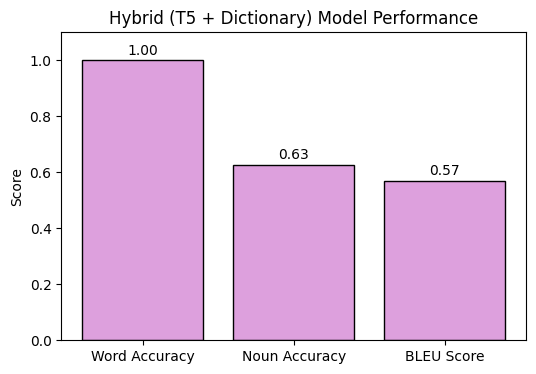

In [2]:
import matplotlib.pyplot as plt

# Hybrid (T5 + Dictionary) results
hybrid_metrics = {
    "Word Accuracy": 1.0000,
    "Noun Accuracy": 0.6276,
    "BLEU Score": 0.5699
}

plt.figure(figsize=(6,4))
plt.bar(hybrid_metrics.keys(), hybrid_metrics.values(), color="plum", edgecolor="black")

# Labels
plt.ylabel("Score")
plt.ylim(0,1.1)  # extend a bit since Word Accuracy = 1.0
plt.title("Hybrid (T5 + Dictionary) Model Performance")

# Annotate values
for i, (metric, value) in enumerate(hybrid_metrics.items()):
    plt.text(i, value+0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()
